In [94]:
!pip install pandas matplotlib yfinance

In [95]:
# Import libraries yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from math import sqrt
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

In [96]:
# Define kode saham dan rentang waktu (1 tahun cukup)
stock_symbol = 'AAPL'
start_date = '2022-10-31'
end_date = '2023-10-31'

In [97]:
# Ambil bagian historical data
df = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [98]:
# Pilih kolom 'Open' (butuhnya opening price)
ts = df['Open'].values

In [99]:
print(ts)

[153.16000366 155.08000183 148.94999695 142.05999756 142.08999634
 137.11000061 140.41000366 138.5        141.24000549 145.82000732
 148.97000122 152.22000122 149.13000488 146.42999268 152.30999756
 150.16000366 148.13000488 149.44999695 148.30999756 145.13999939
 144.28999329 141.3999939  148.21000671 145.96000671 147.77000427
 147.07000732 142.19000244 142.36000061 142.33999634 142.69999695
 149.5        145.3500061  141.11000061 136.69000244 135.11000061
 131.38999939 132.97999573 134.3500061  130.91999817 131.38000488
 129.66999817 127.98999786 128.41000366 130.27999878 126.88999939
 127.12999725 126.01000214 130.47000122 130.25999451 131.25
 133.88000488 132.02999878 134.83000183 136.82000732 134.08000183
 135.27999878 138.11999512 140.30999756 140.88999939 143.16999817
 143.16000366 144.96000671 142.69999695 143.97000122 148.8999939
 148.02999878 152.57000732 150.63999939 153.88000488 153.77999878
 149.46000671 150.94999695 152.11999512 153.11000061 153.50999451
 152.3500061  150

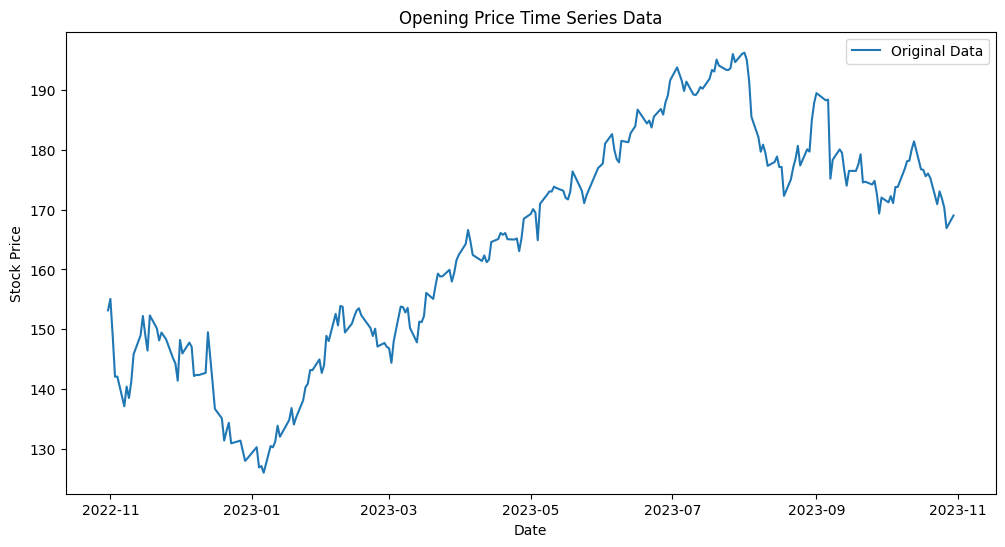

In [100]:
# Display time series plot dari original data opening price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Open'], label='Original Data')
plt.title('Opening Price Time Series Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [101]:
# Normalisasi data
scaler = StandardScaler()
ts = scaler.fit_transform(np.array(ts).reshape(-1, 1))

In [102]:
# Prepare X_train dan X_test
seq_length = 30

X_train = []
y_train = []

for i in range(len(ts) - seq_length):
    X_train.append(ts[i:i + seq_length])
    y_train.append(ts[i + seq_length])

In [103]:
# Memastikan X_train dan y_train adalah numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

In [104]:
# Split data menjadi training dan testing (80% training, 20% testing)
train_size = int(len(X_train) * 0.8)
X_train, X_test = X_train[:train_size], X_train[train_size:]
y_train, y_test = y_train[:train_size], y_train[train_size:]

In [105]:
# Model Architecture
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))  # tambah dropout buat prevent overfitting
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

In [106]:
# Training Parameters
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # Early stopping callback

In [107]:
# Model Training
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
5/5 [==============================] - 6s 330ms/step - loss: 0.9326 - val_loss: 1.3742
Epoch 2/50
5/5 [==============================] - 1s 145ms/step - loss: 0.5136 - val_loss: 0.3504
Epoch 3/50
5/5 [==============================] - 1s 150ms/step - loss: 0.2750 - val_loss: 16.7258
Epoch 4/50
5/5 [==============================] - 1s 192ms/step - loss: 0.1964 - val_loss: 0.2783
Epoch 5/50
5/5 [==============================] - 1s 297ms/step - loss: 0.1873 - val_loss: 0.2502
Epoch 6/50
5/5 [==============================] - 2s 520ms/step - loss: 0.1517 - val_loss: 0.7413
Epoch 7/50
5/5 [==============================] - 2s 382ms/step - loss: 0.1114 - val_loss: 3.0079
Epoch 8/50
5/5 [==============================] - 1s 279ms/step - loss: 0.0828 - val_loss: 1.3766
Epoch 9/50
5/5 [==============================] - 1s 280ms/step - loss: 0.0911 - val_loss: 1.0517
Epoch 10/50
5/5 [==============================] - 2s 345ms/step - loss: 0.0856 - val_loss: 1.6425
Epoch 11/50
5/5 [=

In [108]:
# Model Evaluation
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

2/2 [==============================] - 1s 31ms/step


In [109]:
# Menghitung RMSE dan MAE
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

In [110]:
# Data Augmentation (di sini pakai Random Noise)
# tambah random noise ke training data
noise = np.random.normal(0, 0.1, X_train.shape)
X_train_noisy = X_train + noise
model.fit(X_train_noisy, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
5/5 [==============================] - 1s 157ms/step - loss: 0.1640 - val_loss: 0.5946
Epoch 2/50
5/5 [==============================] - 1s 148ms/step - loss: 0.1346 - val_loss: 4.7796
Epoch 3/50
5/5 [==============================] - 1s 151ms/step - loss: 0.1326 - val_loss: 1.8947
Epoch 4/50
5/5 [==============================] - 1s 241ms/step - loss: 0.0795 - val_loss: 2.6661
Epoch 5/50
5/5 [==============================] - 1s 267ms/step - loss: 0.0722 - val_loss: 2.7939
Epoch 6/50
5/5 [==============================] - 1s 205ms/step - loss: 0.0765 - val_loss: 1.0230
Epoch 7/50
5/5 [==============================] - 1s 146ms/step - loss: 0.0958 - val_loss: 2.1735
Epoch 8/50
5/5 [==============================] - 1s 150ms/step - loss: 0.0753 - val_loss: 1.8411
Epoch 9/50
5/5 [==============================] - 1s 147ms/step - loss: 0.0846 - val_loss: 0.4849
Epoch 10/50
5/5 [==============================] - 1s 144ms/step - loss: 0.0680 - val_loss: 0.9508
Epoch 11/50
5/5 [==

In [111]:
# Feature Engineering (di sini pake Adding Volume Data, untuk menambahkan informasi lebih ke analisis time series)
df['Volume'] = df['Volume'] / 1e7
additional_features = df['Volume'].values

In [112]:
# Concatenate additional features dan X_train
additional_features = additional_features.reshape(-1, 1, 1)
additional_features = additional_features[-len(X_train):]
X_train = np.concatenate((X_train, additional_features), axis=1)

In [113]:
# Ensemble Methods
X_train_2d = X_train.reshape(X_train.shape[0], -1)
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train_2d, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [114]:
from tensorflow.keras.regularizers import l2

# Regularization (L2 Regularization)
model = keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1), kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(LSTM(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

In [115]:
# Menerapkan k-fold cross-validation (buat improve performance dari modelnya)
tscv = TimeSeriesSplit(n_splits=5)
rmses = []
maes = []

for train_index, test_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index, :seq_length], X_train[test_index, :seq_length]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Define dan train neural network model
    model = keras.Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=50, batch_size=32, callbacks=[early_stopping])

    # Evaluasi model
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)

    rmse = sqrt(mean_squared_error(y_val_fold, model.predict(X_val_fold)))
    mae = mean_absolute_error(y_val_fold, model.predict(X_val_fold))

    rmses.append(rmse)
    maes.append(mae)

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 2.7360 - val_loss: 0.6076
Epoch 2/50
1/1 [==============================] - 0s 217ms/step - loss: 2.5804 - val_loss: 0.5544
Epoch 3/50
1/1 [==============================] - 0s 200ms/step - loss: 2.4827 - val_loss: 0.4881
Epoch 4/50
1/1 [==============================] - 0s 206ms/step - loss: 2.2910 - val_loss: 0.3968
Epoch 5/50
1/1 [==============================] - 0s 209ms/step - loss: 2.0334 - val_loss: 0.2740
Epoch 6/50
1/1 [==============================] - 0s 293ms/step - loss: 1.6426 - val_loss: 0.1261
Epoch 7/50
1/1 [==============================] - 0s 452ms/step - loss: 1.1973 - val_loss: 0.1315
Epoch 8/50
1/1 [==============================] - 0s 359ms/step - loss: 0.6090 - val_loss: 3.5907
Epoch 9/50
1/1 [==============================] - 0s 462ms/step - loss: 1.5953 - val_loss: 0.9574
Epoch 10/50
1/1 [==============================] - 0s 420ms/step - loss: 0.8475 - val_loss: 0.2184
Epoch 11/50
1/1 [=====

In [116]:
# Menghitung average RMSE dari cross-validation
mean_rmse = np.mean(rmses)
mean_mae = np.mean(maes)
print(f"Average RMSE: {mean_rmse}")
print(f"Average MAE: {mean_mae}")

Average RMSE: 0.33450753277186496
Average MAE: 0.29304302849942565


In [117]:
# Predictions untuk test data (X_test)
y_pred_test = model.predict(X_test)
y_pred_test = scaler.inverse_transform(y_pred_test)

2/2 [==============================] - 0s 29ms/step


In [118]:
print(y_pred_test)

[[184.30829]
 [183.65883]
 [183.05211]
 [182.53029]
 [182.08868]
 [181.77243]
 [181.5726 ]
 [181.47409]
 [181.41113]
 [181.34021]
 [181.2898 ]
 [181.22537]
 [181.14426]
 [181.0419 ]
 [180.93858]
 [180.85158]
 [180.76357]
 [180.67665]
 [180.55304]
 [180.41435]
 [180.26576]
 [180.0876 ]
 [179.87698]
 [179.64656]
 [179.38753]
 [179.14192]
 [178.85619]
 [178.54318]
 [178.22284]
 [177.9006 ]
 [177.63719]
 [177.3945 ]
 [177.20462]
 [177.0299 ]
 [176.89998]
 [176.81085]
 [176.77307]
 [176.75972]
 [176.85724]
 [176.92487]
 [176.95761]
 [176.97151]
 [176.97855]
 [176.96616]
 [176.88484]]


In [119]:
# RMSE dan MAE dari test data
rmse_test = sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE for Test Data: {rmse_test}")
print(f"MAE for Test Data: {mae_test}")

RMSE for Test Data: 178.89187785669648
MAE for Test Data: 178.8803624482461


In [120]:
# forecasting
forecast_days = 5
X_forecast = np.copy(X_test[-1])

forecasted_values = []

for _ in range(forecast_days):
    forecasted_value = model.predict(X_forecast.reshape(1, seq_length, 1))
    forecasted_values.append(forecasted_value[0, 0])

    X_forecast = np.roll(X_forecast, -1)
    X_forecast[-1] = forecasted_value

forecasted_values = scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))

1/1 [==============================] - 0s 30ms/step


In [121]:
print(forecasted_values)

[[176.88484]
 [176.78932]
 [176.6911 ]
 [176.59796]
 [176.56102]]


In [122]:
# date range buat forecast
last_date = df.index[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_days + 1)[1:]

# date range buat test data
test_dates = df.index[-len(y_pred_test):]

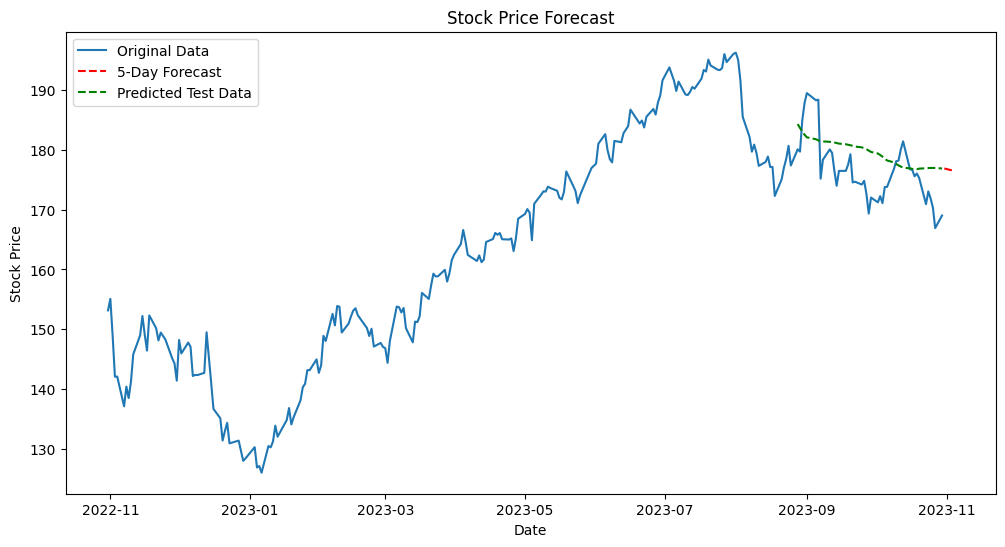

In [123]:
# Plot dari original data, predicted test data, dan forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Open'], label='Original Data')
plt.plot(forecast_dates, forecasted_values, label='5-Day Forecast', linestyle='--', color='red')
plt.plot(test_dates, y_pred_test, label='Predicted Test Data', linestyle='--', color='green') # Adding the predicted test data
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()